<a href="https://www.bigdatauniversity.com"><img src="https://ibm.box.com/shared/static/cw2c7r3o20w9zn8gkecaeyjhgw3xdgbj.png" width="400" align="center"></a>

<h1 align="center"><font size="5">Classification with Python</font></h1>

In this notebook we try to practice all the classification algorithms that we learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Lets first load required libraries:

In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

### About dataset

This dataset is about past loans. The __Loan_train.csv__ data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |

Lets download the dataset

In [2]:
!wget -O loan_train.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv

--2019-12-31 03:54:55--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

100%[======================================>] 23,101      --.-K/s   in 0.002s  

2019-12-31 03:54:55 (13.3 MB/s) - ‘loan_train.csv’ saved [23101/23101]



### Load Data From CSV File  

In [3]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [4]:
df.shape

(346, 10)

### Convert to date time object 

In [5]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing



Let’s see how many of each class is in our data set 

In [6]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection 


Lets plot some columns to underestand data better:

In [7]:
# notice: installing seaborn might takes a few minutes
#!conda install -c anaconda seaborn -y

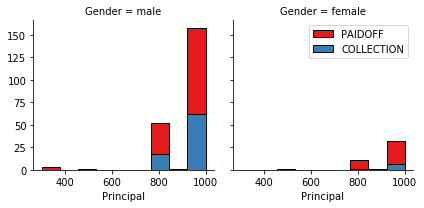

In [8]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

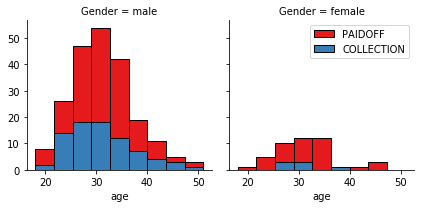

In [9]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction

### Lets look at the day of the week people get the loan 

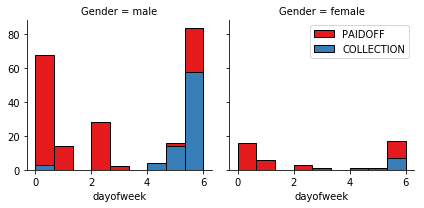

In [10]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week dont pay it off, so lets use Feature binarization to set a threshold values less then day 4 

In [11]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values

Lets look at gender:

In [12]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Lets convert male to 0 and female to 1:


In [13]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df['loan_status'].replace(to_replace = ['PAIDOFF', 'COLLECTION'], value = [0, 1], inplace = True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,0,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,0,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,0,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,0,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,0,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding  
#### How about education?

In [14]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              0              0.750000
                      1              0.250000
High School or Below  0              0.741722
                      1              0.258278
Master or Above       0              0.500000
                      1              0.500000
college               0              0.765101
                      1              0.234899
Name: loan_status, dtype: float64

#### Feature befor One Hot Encoding

In [15]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame 

In [16]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature selection

Lets defind feature sets, X:

In [17]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


What are our lables?

In [18]:
y = df['loan_status'].values
y[0:5]

array([0, 0, 0, 0, 0])

## Normalize Data 

Data Standardization give data zero mean and unit variance (technically should be done after train test split )

In [19]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:1: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  if __name__ == '__main__':


array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

# Classification 

Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:
- K Nearest Neighbor(KNN)
- Decision Tree
- Support Vector Machine
- Logistic Regression



__ Notice:__ 
- You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
- You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
- You should include the code of the algorithm in the following cells.

# Train-Test Split

In [20]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (276, 8) (276,)
Test set: (70, 8) (70,)


# 1. K Nearest Neighbor (KNN)
Notice: You should find the best k to build the model with the best accuracy.  
**warning:** You should not use the __loan_test.csv__ for finding the best k, however, you can split your train_loan.csv into train and test to find the best __k__.

## 1.1. Import Libraries

Classifier implementing the k-nearest neighbors vote.

In [21]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

## 1.2. Choosing K

In [22]:
Ks = 7

mean_acc = np.zeros((Ks - 1))
std_acc = np.zeros((Ks - 1))

for n in range(1,Ks):
    
    #Train Model and Predict  
    KNCmodel = KNeighborsClassifier(n_neighbors = n).fit(X_train, y_train)
    yhat = KNCmodel.predict(X_test)
    mean_acc[n - 1] = metrics.accuracy_score(y_test, yhat)

    
    std_acc[n - 1] = np.std(yhat == y_test) / np.sqrt(yhat.shape[0])

mean_acc

array([0.65714286, 0.74285714, 0.7       , 0.75714286, 0.71428571,
       0.77142857])

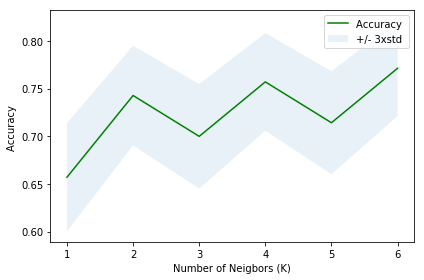

In [23]:
plt.plot(range(1, Ks), mean_acc, 'g')
plt.fill_between(range(1, Ks), mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha = 0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Neigbors (K)')
plt.tight_layout()
plt.show()

In [24]:
print( "The best accuracy was with", mean_acc.max(), "with k =", mean_acc.argmax() + 1) 

The best accuracy was with 0.7714285714285715 with k = 6


## 1.3. Training

In [25]:
k = mean_acc.argmax() + 1

KNCmodel = KNeighborsClassifier(n_neighbors = k).fit(X_train, y_train)
KNCmodel

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=6, p=2,
           weights='uniform')

## 1.4. Predicting

In [26]:
yhat = KNCmodel.predict(X_test)
yhat[0:5]

array([1, 0, 0, 0, 0])

## 1.5. Accuracy Evaluation

In [27]:
print("Train set Accuracy: ", metrics.accuracy_score(y_train, KNCmodel.predict(X_train)))
print("Test set Accuracy: ", metrics.accuracy_score(y_test, yhat))

Train set Accuracy:  0.8079710144927537
Test set Accuracy:  0.7714285714285715


# Decision Tree

## 2.1. Import Libraries

In [28]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.externals.six import StringIO
from sklearn import tree
#!conda install -c conda-forge pydotplus -y
import pydotplus
import matplotlib.image as mpimg

## 2.2. Choosing Max Depth

In [29]:
Dpth = 20

mean_acc = np.zeros((Dpth - 1))
std_acc = np.zeros((Dpth - 1))

for n in range(1, Dpth):
    DTCmodel = DecisionTreeClassifier(criterion = 'entropy', max_depth = n).fit(X_train, y_train)
    yhat = DTCmodel.predict(X_test)
    mean_acc[n - 1] = metrics.accuracy_score(y_test, yhat)
    std_acc[n - 1] = np.std(yhat == y_test) / np.sqrt(yhat.shape[0])

mean_acc    

array([0.82857143, 0.82857143, 0.82857143, 0.71428571, 0.8       ,
       0.72857143, 0.74285714, 0.71428571, 0.72857143, 0.74285714,
       0.72857143, 0.72857143, 0.72857143, 0.72857143, 0.72857143,
       0.72857143, 0.72857143, 0.72857143, 0.72857143])

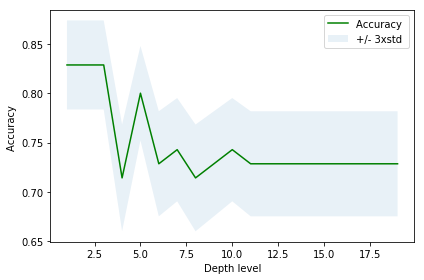

In [30]:
plt.plot(range(1, Dpth), mean_acc, 'g')
plt.fill_between(range(1, Dpth), mean_acc - 1 * std_acc, mean_acc + 1 * std_acc, alpha = 0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Depth level')
plt.tight_layout()
plt.show()

## 2.3. Training

In [31]:
DTCmodel = DecisionTreeClassifier(criterion = "entropy", max_depth = 5)

DTCmodel.fit(X_train, y_train)
DTCmodel

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

## 2.4. Predicting

In [32]:
yhat = DTCmodel.predict(X_test)
print (yhat[0:5])
print (y_test[0:5])

[1 0 0 0 0]
[1 0 1 0 0]


## 2.5. Accuracy Evaluation

In [33]:
print("Decision Trees's Accuracy:", metrics.accuracy_score(y_test, yhat))

Decision Trees's Accuracy: 0.8


## 2.6. Tree Visualization

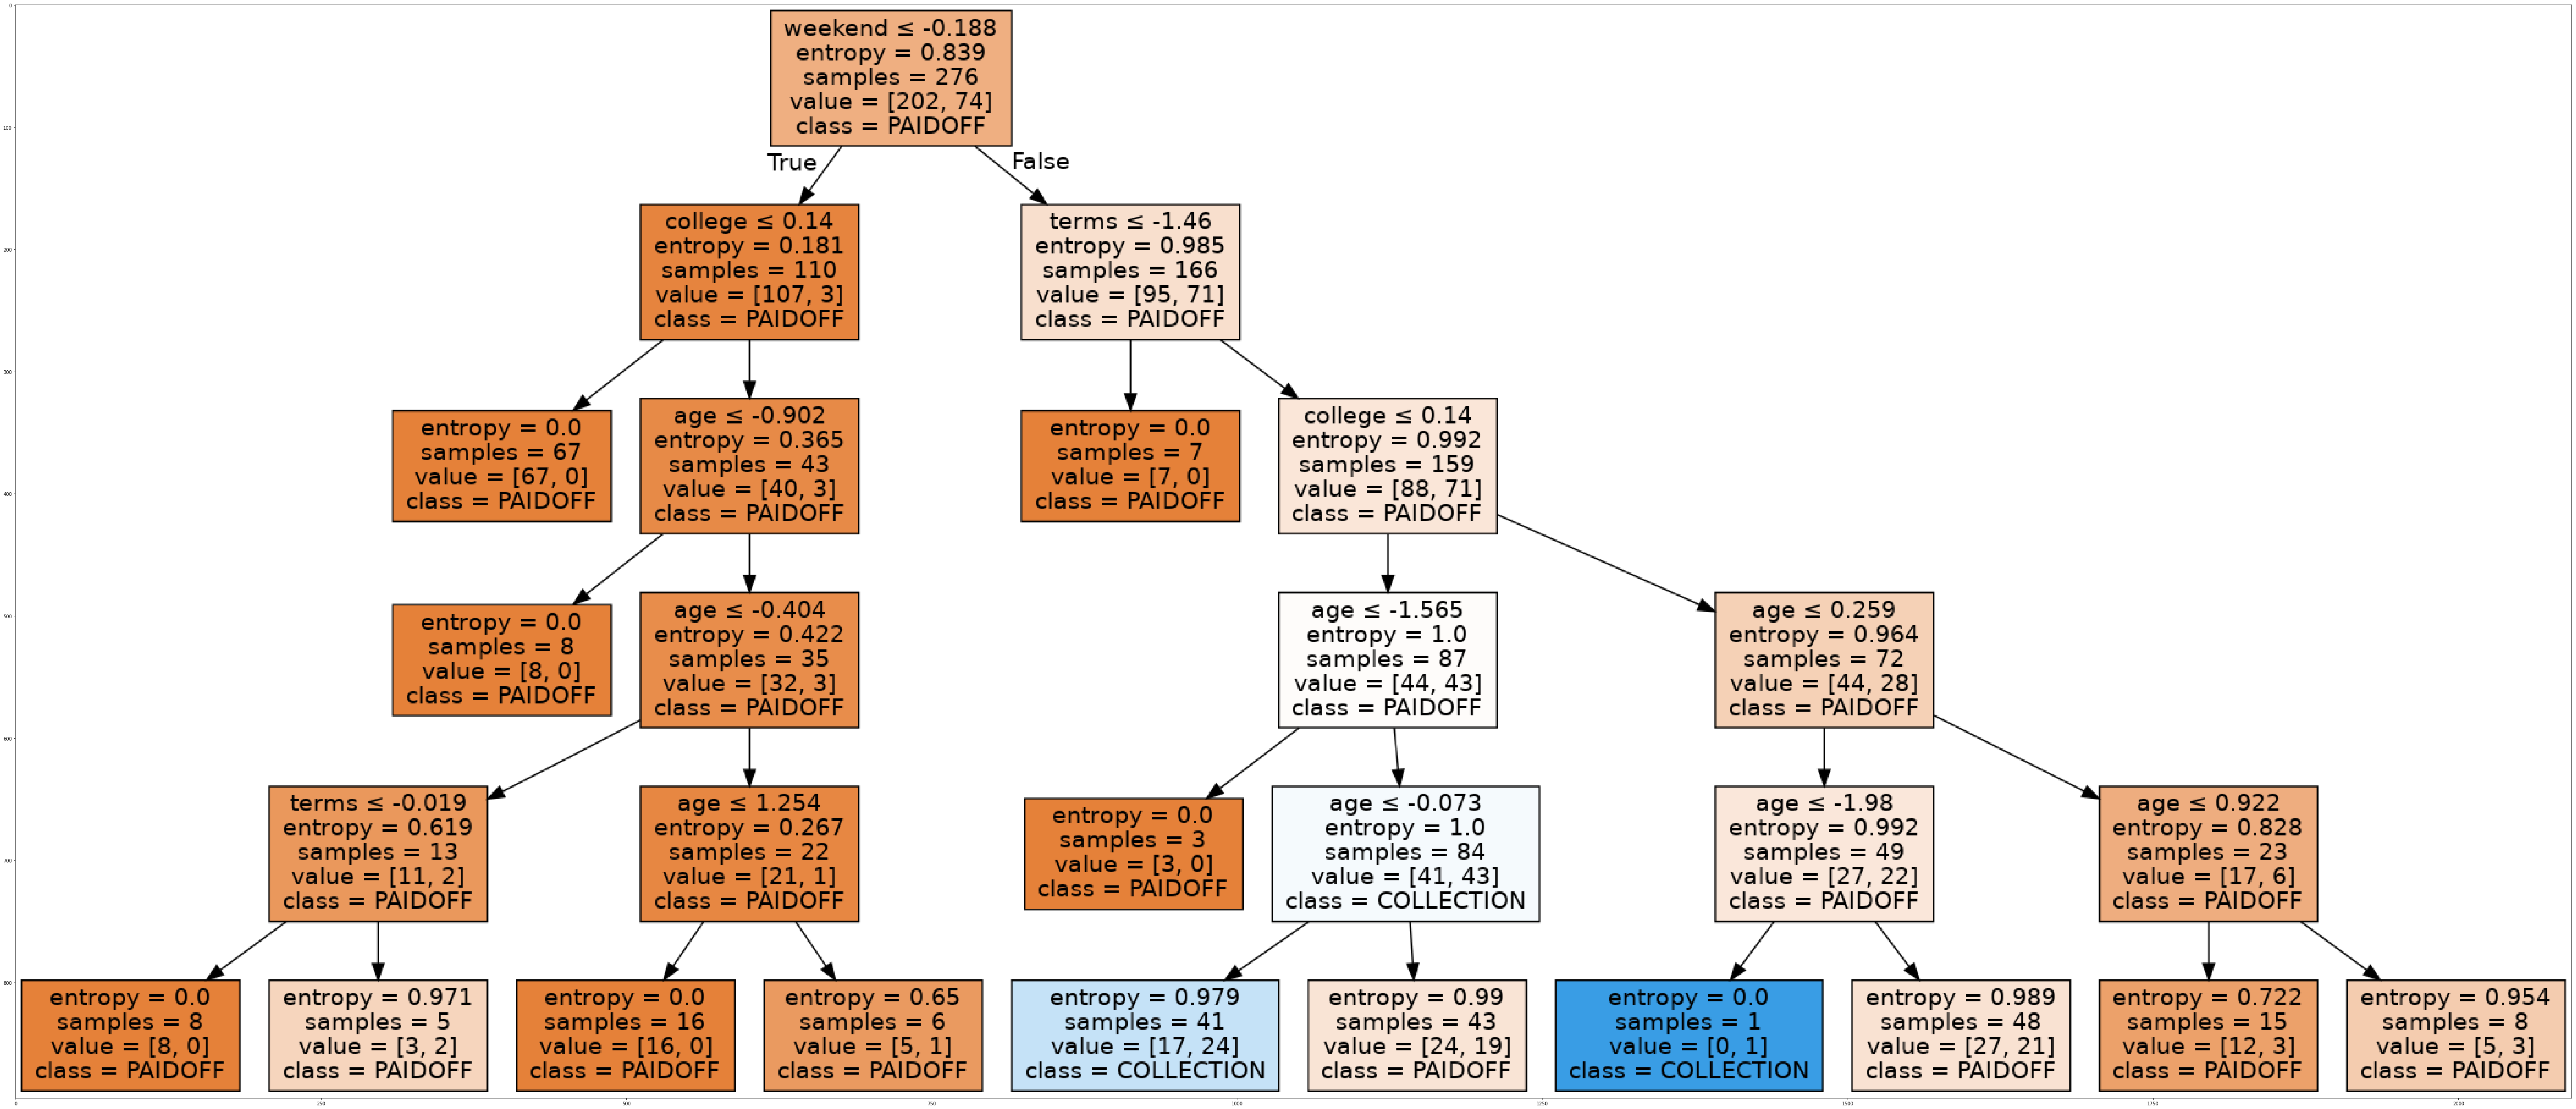

In [34]:
dot_data = StringIO()

filename = "DTCtree.png"
featureNames = Feature.columns
targetNames = df['loan_status'].unique().tolist()

out = tree.export_graphviz(DTCmodel, feature_names = featureNames, out_file = dot_data, class_names = ['PAIDOFF', 'COLLECTION'], filled = True, special_characters = True, rotate = False)  

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png(filename)
img = mpimg.imread(filename)

plt.figure(figsize = (100, 200))
plt.imshow(img, interpolation = 'nearest')

In [35]:
list(map(str, np.unique(y_train)))

['0', '1']

# 3. Support Vector Machine

## 3.1. Import libraries

In [36]:
from sklearn import svm
from sklearn.metrics import classification_report, confusion_matrix

## 3.2 Training

In [37]:
SVMmodel = svm.SVC(kernel = 'rbf', gamma = 'scale')
SVMmodel.fit(X_train, y_train) 

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

## 3.3. Predicting

In [38]:
yhat = SVMmodel.predict(X_test)
yhat[0:5]

array([0, 0, 1, 0, 0])

## 3.4. Accuracy Evaluation

In [39]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

              precision    recall  f1-score   support

           0       0.83      0.83      0.83        58
           1       0.17      0.17      0.17        12

   micro avg       0.71      0.71      0.71        70
   macro avg       0.50      0.50      0.50        70
weighted avg       0.71      0.71      0.71        70

Confusion matrix, without normalization
[[48 10]
 [10  2]]


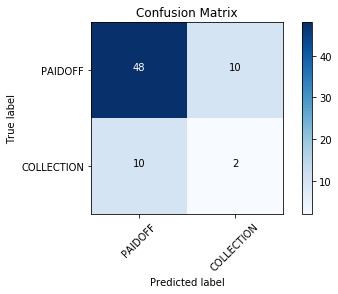

In [40]:
SVMmodel_matrix = confusion_matrix(y_test, yhat, labels = [0, 1])
np.set_printoptions(precision = 2)

print(classification_report(y_test, yhat))

plt.figure()
plot_confusion_matrix(SVMmodel_matrix, classes = ['PAIDOFF','COLLECTION'], normalize = False, title = 'Confusion Matrix')

# 4. Logistic Regression

## 4.1. Import libraries

In [41]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

## 4.2. Training

In [57]:
LRmodel = LogisticRegression(C = 0.01).fit(X_train, y_train)

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


## 4.3. Predicting

In [58]:
yhat = LRmodel.predict(X_test)
yhat_proba = LRmodel.predict_proba(X_test)
print(yhat.size, yhat_proba.size)

70 140


## 4.4. Accuracy Evaluation

              precision    recall  f1-score   support

           0       0.83      0.95      0.89        58
           1       0.25      0.08      0.12        12

   micro avg       0.80      0.80      0.80        70
   macro avg       0.54      0.52      0.51        70
weighted avg       0.73      0.80      0.76        70

Confusion matrix, without normalization
[[55  3]
 [11  1]]


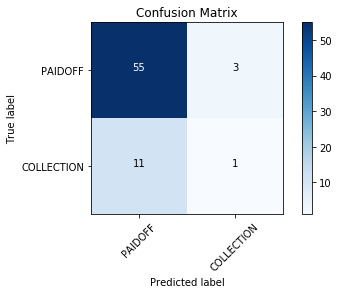

In [59]:
print (classification_report(y_test, yhat))

LRmodel_matrix = confusion_matrix(y_test, yhat, labels = [0, 1])
np.set_printoptions(precision = 2)

plt.figure()
plot_confusion_matrix(LRmodel_matrix, classes = ['PAIDOFF','COLLECTION'], normalize = False, title = 'Confusion Matrix')

# Model Evaluation using Test set

In [60]:
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

First, download and load the test set:

In [46]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2019-12-31 03:55:12--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

100%[======================================>] 3,642       --.-K/s   in 0s      

2019-12-31 03:55:12 (416 MB/s) - ‘loan_test.csv’ saved [3642/3642]



### Load Test set for evaluation 

In [47]:
test_df = pd.read_csv('loan_test.csv')
test_df.tail()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
49,348,348,COLLECTION,1000,30,9/11/2016,10/10/2016,32,High School or Below,male
50,349,349,COLLECTION,800,15,9/11/2016,9/25/2016,29,college,male
51,369,369,COLLECTION,1000,30,9/11/2016,10/10/2016,37,High School or Below,male
52,370,370,COLLECTION,800,15,9/11/2016,9/25/2016,36,High School or Below,male
53,396,396,COLLECTION,1000,30,9/12/2016,10/11/2016,33,High School or Below,male


## Pre-processing

In [48]:
test_df['due_date'] = pd.to_datetime(test_df['due_date'])
test_df['effective_date'] = pd.to_datetime(test_df['effective_date'])
test_df.dtypes

Unnamed: 0                 int64
Unnamed: 0.1               int64
loan_status               object
Principal                  int64
terms                      int64
effective_date    datetime64[ns]
due_date          datetime64[ns]
age                        int64
education                 object
Gender                    object
dtype: object

In [49]:
test_df['Gender'].replace(to_replace = ['male','female'], value=[0,1],inplace=True)
test_df['loan_status'].replace(to_replace = ['PAIDOFF', 'COLLECTION'], value = [0, 1], inplace = True)
test_df.tail()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
49,348,348,1,1000,30,2016-09-11,2016-10-10,32,High School or Below,0
50,349,349,1,800,15,2016-09-11,2016-09-25,29,college,0
51,369,369,1,1000,30,2016-09-11,2016-10-10,37,High School or Below,0
52,370,370,1,800,15,2016-09-11,2016-09-25,36,High School or Below,0
53,396,396,1,1000,30,2016-09-12,2016-10-11,33,High School or Below,0


In [50]:
test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek
test_df['weekend'] = test_df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
test_df.tail()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
49,348,348,1,1000,30,2016-09-11,2016-10-10,32,High School or Below,0,6,1
50,349,349,1,800,15,2016-09-11,2016-09-25,29,college,0,6,1
51,369,369,1,1000,30,2016-09-11,2016-10-10,37,High School or Below,0,6,1
52,370,370,1,800,15,2016-09-11,2016-09-25,36,High School or Below,0,6,1
53,396,396,1,1000,30,2016-09-12,2016-10-11,33,High School or Below,0,0,0


In [51]:
test_Feature = test_df[['Principal','terms','age','Gender','weekend']]
test_Feature = pd.concat([test_Feature,pd.get_dummies(test_df['education'])], axis=1)
test_Feature.drop(['Master or Above'], axis = 1,inplace=True)
test_Feature.tail()

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
49,1000,30,32,0,1,0,1,0
50,800,15,29,0,1,0,0,1
51,1000,30,37,0,1,0,1,0
52,800,15,36,0,1,0,1,0
53,1000,30,33,0,0,0,1,0


In [52]:
test_X = test_Feature
test_X[49:]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
49,1000,30,32,0,1,0,1,0
50,800,15,29,0,1,0,0,1
51,1000,30,37,0,1,0,1,0
52,800,15,36,0,1,0,1,0
53,1000,30,33,0,0,0,1,0


In [53]:
test_y = test_df['loan_status'].values
test_y[49:]

array([1, 1, 1, 1, 1])

In [54]:
test_X = preprocessing.StandardScaler().fit(test_X).transform(test_X)
test_X[49:]

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:1: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  if __name__ == '__main__':


array([[ 0.49,  0.93,  0.03, -0.51,  0.77, -0.42,  1.25, -0.86],
       [-0.67, -0.79, -0.48, -0.51,  0.77, -0.42, -0.8 ,  1.16],
       [ 0.49,  0.93,  0.87, -0.51,  0.77, -0.42,  1.25, -0.86],
       [-0.67, -0.79,  0.7 , -0.51,  0.77, -0.42,  1.25, -0.86],
       [ 0.49,  0.93,  0.2 , -0.51, -1.3 , -0.42,  1.25, -0.86]])

## Evaluation Metrics

In [55]:
KNCmodel.predict(test_X)

array([0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 1, 0])

In [62]:
KNCj = jaccard_similarity_score(test_y, KNCmodel.predict(test_X))

KNCF1 = f1_score(test_y, KNCmodel.predict(test_X), average = 'weighted')

DTCj = jaccard_similarity_score(test_y, DTCmodel.predict(test_X))

DTCF1 = f1_score(test_y, DTCmodel.predict(test_X), average = 'weighted')

SVMj = jaccard_similarity_score(test_y, SVMmodel.predict(test_X))

SVMF1 = f1_score(test_y, SVMmodel.predict(test_X), average = 'weighted')

LRj = jaccard_similarity_score(test_y, LRmodel.predict(test_X))

LRF1 = f1_score(test_y, LRmodel.predict(test_X), average = 'weighted')

LRLL = log_loss(test_y, LRmodel.predict_proba(test_X))

print('KNN Jaccard: %.2f' % KNCj, 'KNN F1-score: %.2f' % KNCF1)
print('DTC Jaccard: %.2f' % DTCj, 'DTC F1-score: %.2f' % DTCF1)
print('SVM Jaccard: %.2f' % SVMj, 'SVM F1-score: %.2f' % SVMF1)
print('LR Jaccard: %.2f' % LRj, 'LR F1-score: %.2f' % LRF1, 'LR LogLoss: %.2f' % LRLL)

KNN Jaccard: 0.76 KNN F1-score: 0.73
DTC Jaccard: 0.74 DTC F1-score: 0.71
SVM Jaccard: 0.74 SVM F1-score: 0.71
LR Jaccard: 0.74 LR F1-score: 0.63 LR LogLoss: 0.58


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# Report
You should be able to report the accuracy of the built model using different evaluation metrics:

| Algorithm          | Jaccard | F1-score | LogLoss |
|--------------------|---------|----------|---------|
| KNN                | ?       | ?        | NA      |
| Decision Tree      | ?       | ?        | NA      |
| SVM                | ?       | ?        | NA      |
| LogisticRegression | ?       | ?        | ?       |

<h2>Want to learn more?</h2>

IBM SPSS Modeler is a comprehensive analytics platform that has many machine learning algorithms. It has been designed to bring predictive intelligence to decisions made by individuals, by groups, by systems – by your enterprise as a whole. A free trial is available through this course, available here: <a href="http://cocl.us/ML0101EN-SPSSModeler">SPSS Modeler</a>

Also, you can use Watson Studio to run these notebooks faster with bigger datasets. Watson Studio is IBM's leading cloud solution for data scientists, built by data scientists. With Jupyter notebooks, RStudio, Apache Spark and popular libraries pre-packaged in the cloud, Watson Studio enables data scientists to collaborate on their projects without having to install anything. Join the fast-growing community of Watson Studio users today with a free account at <a href="https://cocl.us/ML0101EN_DSX">Watson Studio</a>

<h3>Thanks for completing this lesson!</h3>

<h4>Author:  <a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a></h4>
<p><a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a>, PhD is a Data Scientist in IBM with a track record of developing enterprise level applications that substantially increases clients’ ability to turn data into actionable knowledge. He is a researcher in data mining field and expert in developing advanced analytic methods like machine learning and statistical modelling on large datasets.</p>

<hr>

<p>Copyright &copy; 2018 <a href="https://cocl.us/DX0108EN_CC">Cognitive Class</a>. This notebook and its source code are released under the terms of the <a href="https://bigdatauniversity.com/mit-license/">MIT License</a>.</p>